In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate the interaction strengths of different sRNA pairs interacting

## Imports

In [20]:
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config, expand_config
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
jax.config.update('jax_platform_name', 'cpu')

jax.devices()



[CpuDevice(id=0)]

# Choose sRNA species

In [7]:
fn_EcoCyc = '../data/sRNA/EcoCyc/EcoCyc_regulatory_RNAs.csv'
ecocyc = pd.read_csv(fn_EcoCyc)
fn_RNAInter = os.path.join('..', 'data', 'sRNA', 'RNAInter', 'Download_data_RR.csv')
rnainter = pd.read_csv(fn_RNAInter)
# data = pd.concat([pd.read_csv(fn_RNAInter), pd.read_csv(fn_EcoCyc)])
try:
    rnainter = rnainter.drop(columns=['Unnamed: 0'])
except:
    pass


### Write to sRNA

In [8]:
circuit_fasta = os.path.join('data', 'ecocyc.fasta')
circuit_fasta_d = {}
with open(circuit_fasta, 'w') as f:

    for n in list(ecocyc['Common-Name'].unique()):
        circuit_fasta_d[n] = ecocyc[ecocyc['Common-Name'] == n]['Sequence - DNA sequence'].iloc[0]
        f.write('>' + n.replace(' ', '_') + '\n')
        f.write(circuit_fasta_d[n])
        f.write('\n')

In [9]:
config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data_path": circuit_fasta,
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True
    },
    "mutations_args": {
        "algorithm": "random",
        "mutation_counts": 0,
        "mutation_nums_within_sequence": [1, 3, 5, 20],
        "mutation_nums_per_position": 1,
        "concurrent_species_to_mutate": "single_species_at_a_time",
        "seed": 0
    },
    "signal": {
        "inputs": [ecocyc['Common-Name'].iloc[0]],
        "outputs": [],
        "function_name": "step_function",
        "function_kwargs": {
            "impulse_center": 1,
            "impulse_halfwidth": 5,
            "target": 2
        }
    },
    "simulation": {
        "dt0": 0.1,
        "t0": 0,
        "t1": 100,
        "tmax": 2000,
        "solver": "diffrax",
        "use_batch_mutations": True,
        "interaction_factor": 1,
        "batch_size": 20000,
        "max_circuits": 60000,
        "device": "cpu",
        "threshold_steady_states": 0.05,
        "use_rate_scaling": True
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}

## Simulate

In [10]:
data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)
circuit = construct_circuit_from_cfg(prev_configs=None, config_file=config_file)

len(circuit.model.species)


circuit_manager.py:batch_circuits():600: 	From 1 circuits, a total of 1 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 1 / 1) WARNING
circuit_manager.py:batch_circuits():625: 		Making subcircuits 0 - 1 took 7e-06s WARNING
circuit_manager.py:batch_circuits():631: 	Batching 0 - 20000 circuits (out of 0 - 1 (total: 1)) (Circuits: 0 - 1 of 1) WARNING
circuit_manager.py:run_batch():662: 		Running 1 Subcircuits - ecocyc: compute_interactions WARNING
circuit_manager.py:run_batch():698: 		Method compute_interactions took 397.001813s WARNING
circuit_manager.py:run_batch():662: 		Running 1 Subcircuits - ecocyc: write_results WARNING
circuit_manager.py:run_batch():698: 		Method write_results took 0.000282s WARNING
circuit_manager.py:batch_circuits():645: Single batch: 0:06:37.003674 
Projected time: 397.003674s 
Total time: 0:06:37.003684 WARNING


In [ ]:
modeller = CircuitModeller(result_writer=data_writer, config=config_file)
circuits = modeller.batch_circuits(
    circuits=[circuit],
    write_to_subsystem=True, batch_size=config_file['simulation'].get('batch_size', 100),
    methods={
        "compute_interactions": {},
        # "init_circuits": {'batch': True},
        # "simulate_signal_batch": {'ref_circuit': None,
        #                           'batch': True},
        "write_results": {'no_visualisations': config_file['experiment'].get('no_visualisations', True),
                          'no_numerical': config_file['experiment'].get('no_numerical', False)}
    })

## Visualise

In [43]:
energies = pd.DataFrame(data=circuits[0].interactions.energies, columns=[s.name for s in circuits[0].get_input_species()], index=[s.name for s in circuits[0].get_input_species()])

<AxesSubplot: >

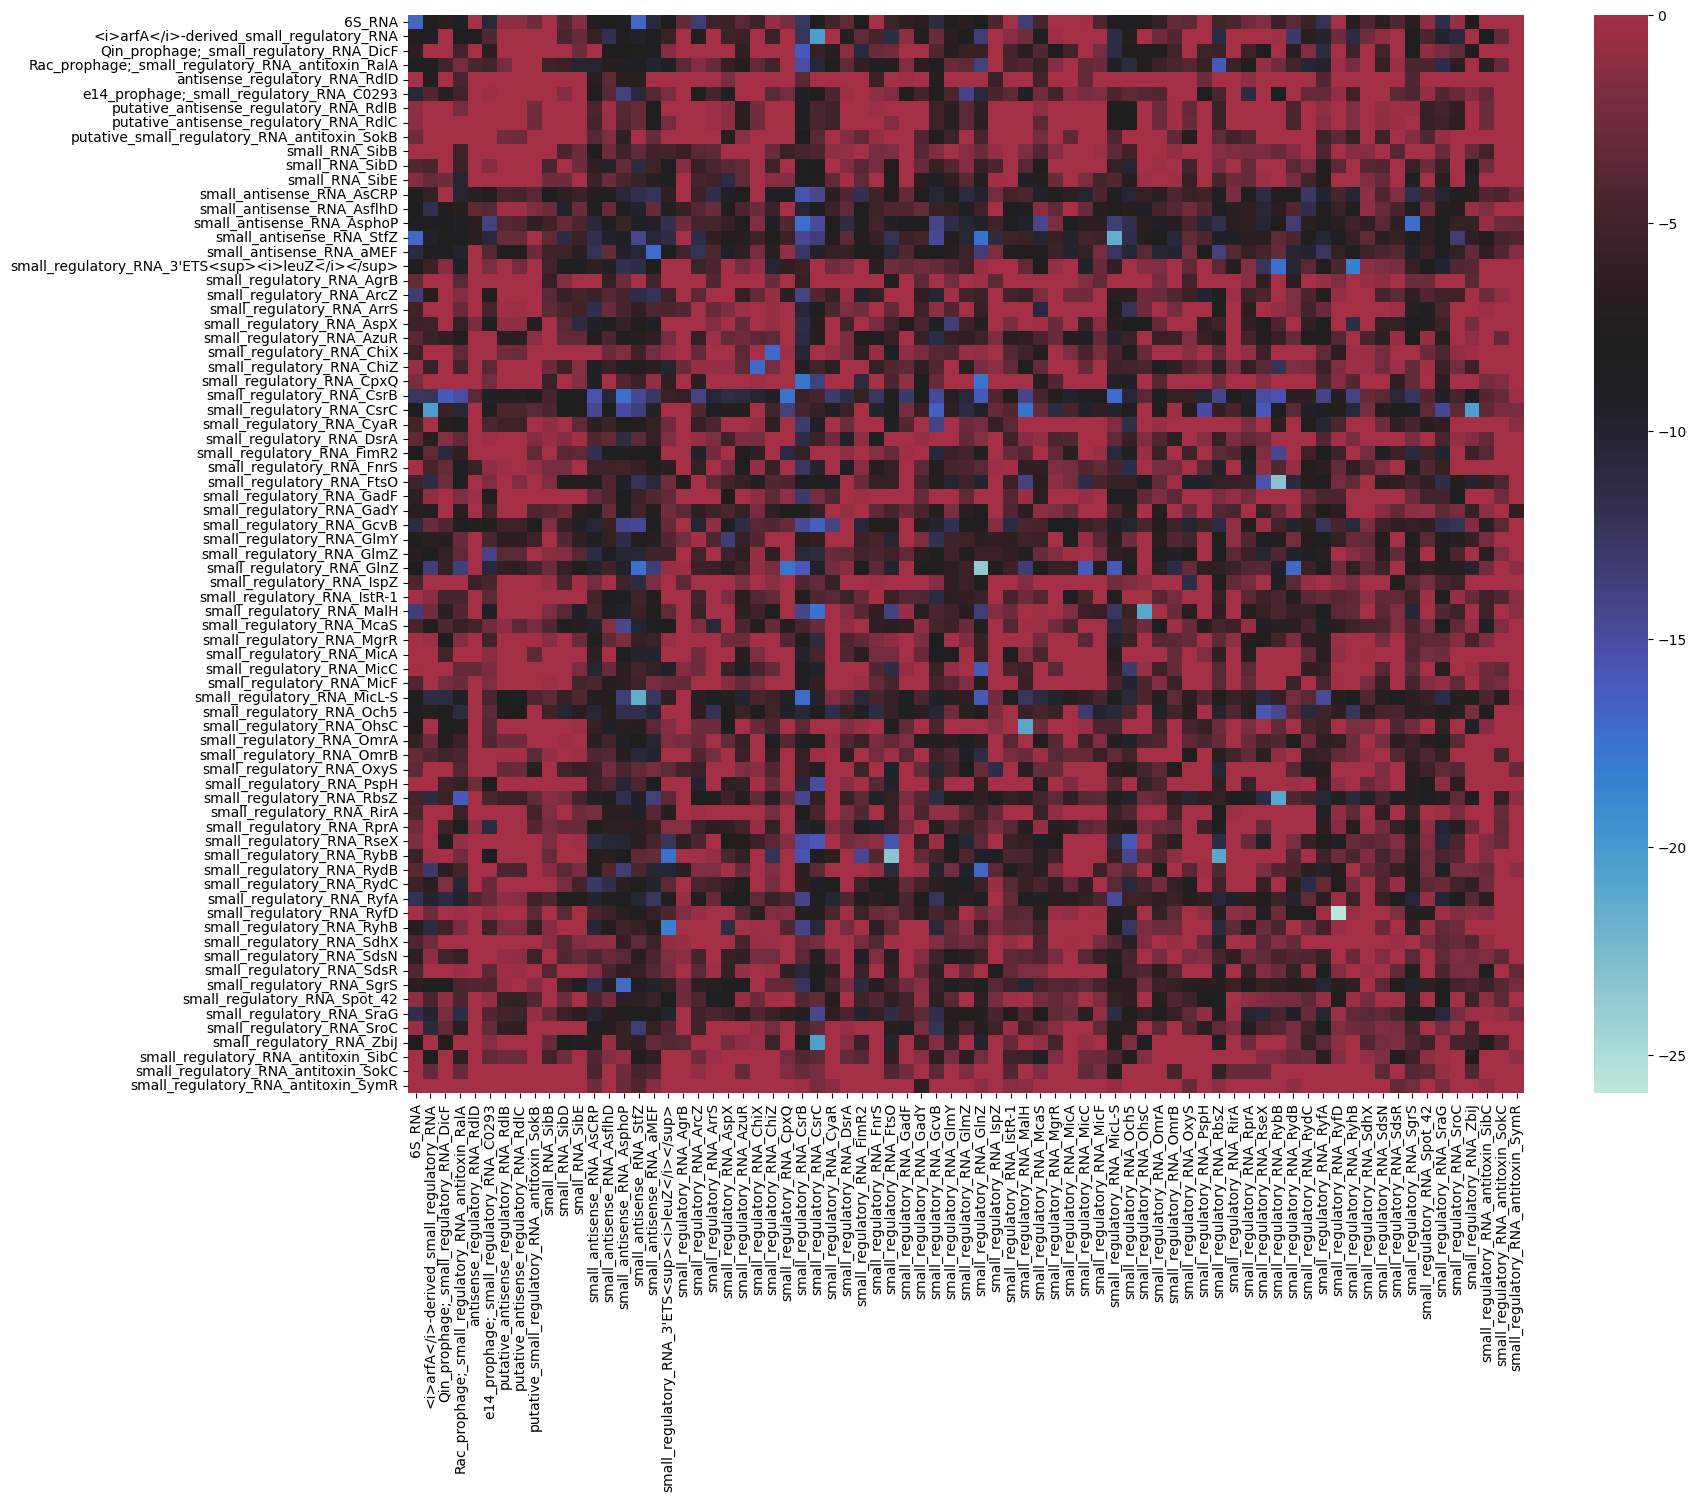

In [44]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(energies, center=-8) #, yticklabels=energies.columns) # cmap='YlGnBu'